# Transitive versus Bridged Treatment Comparisons

The following is a simulation study comparing transitive versus bridged treatment comparisons to compare different arms across two trials. The simulation in particular demonstrates the danger of effect heterogeneity when comparing across different trials and how bridged treatment comparisons offer a way to analytically adjust for these differences in a simplified setting. 

The transitive method compares the two trials directly by adding the risk differences of each trial together (as done in network meta-analysis), whereas the bridged treatment comparison allows for adjustment of observed differences between trial source populations. Further details on bridged treatment comparisons can be found in the following reference:

Zivich PN, Cole SR, Edwards JK, Shook-Sa BE, Breskin A, & Hudgens MG. (2022). Bridged treatment comparisons: an illustrative application in HIV treatment. arXiv preprint arXiv:2206.04445.

### Loading dependencies

In [1]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

print("VERSIONS")
print('Python:     ', sys.version[0:6])
print('NumPy:      ', np.__version__)
print('Pandas:     ', pd.__version__)
print('statsmodels:', sm.__version__)

VERSIONS
Python:      3.6.8 
NumPy:       1.19.5
Pandas:      1.1.5
statsmodels: 0.12.2


In [2]:
from estimators import ClassicalEstimator, BridgeEstimator

In [3]:
np.random.seed(7777777)

Let $A$ indicate the randomly assigned treatment (0: placebo, 1: old version, 2: new version), $T$ indicate the event time, $X$ indicate age (0: young, 1: old), and $S$ indicate the study population (1: target, 0: secondary).

In the simulation, the parameter of interest is risk difference for the event comparing $A=2$ (new version) versus $A=0$ (placebo). This parameter can be written as
$$\theta = \Pr(T^2 < t) - \Pr(T^0 < t)$$
where $T^a$ is the potential outcome under $a$. This is equivalent to
$$\theta = \left[\Pr(T^2 < t) - \Pr(T^1 < t)\right] + \left[\Pr(T^1 < t) - \Pr(T^0 < t)\right]$$
This latter form is used to derive both the transitive and bridged estimators.

### Data generation
Data is generated from a Weibull model (detailed in ``outcome_mechanism``) where there is heterogeneity by age. Further, the treatment impacts both the shape and scale parameters. 

The key distinction between the populations is that the target population consists of more younger individuals compared to the secondary population (i.e., there is more older individuals in the secondary data). As the age distribution differs between populations and the effect of the treatment differs by age, one expects there to be bias when ignoring age in the analysis.

In [4]:
def outcome_mechanism(data):
    # Scale parameter for Weibull
    lambda_ = np.exp(10.
                     + 0.4 * (data['A'] == 1)
                     + 1.5 * (data['A'] == 2)
                     - 3 * data['X']
                     - 0.2 * (data['A'] == 1) * data['X']
                     - 0.5 * (data['A'] == 2) * data['X'])
    # Shape parameter for Weibull
    rho_ = 1.5 + 0.2 * (data['A'] == 1) - 0.2 * (data['A'] == 2)
    # Simulating times from the Weibull model
    time = lambda_ ** (1 / rho_) * np.random.weibull(a=rho_, size=data.shape[0])
    return np.ceil(time).astype(int)


def generate_truth(n):
    # Generating the target population
    d = pd.DataFrame()
    d['X'] = np.random.binomial(n=1, p=0.4, size=n)
    
    # Simulating times under placebo
    d['A'] = 0
    y_a0 = outcome_mechanism(data=d)
    
    # Simulating times under new treatment version
    d['A'] = 2
    y_a2 = outcome_mechanism(data=d)
    
    # Computing the risk difference using the true times
    true_rd = []
    for t in range(0, 366, 1):                # For days 0-365
        event_a0 = np.where(y_a0 <= t, 1, 0)  # ... event at t
        risk_a0 = np.sum(event_a0) / n        # ... risk at t
        event_a2 = np.where(y_a2 <= t, 1, 0)  # ... event at t
        risk_a2 = np.sum(event_a2) / n        # ... risk at t
        true_rd.append(risk_a2 - risk_a0)     # ... store RD
    return np.array(true_rd)


def generate_observed(n1, n0):
    # Generate the active-comparator trial in target
    d1 = pd.DataFrame()
    d1['X'] = np.random.binomial(n=1, p=0.4, size=n1)
    d1['A'] = np.random.binomial(n=1, p=0.5, size=n1) + 1
    d1['T'] = outcome_mechanism(data=d1)
    d1['delta'] = np.where(d1['T'] <= 365, 1, 0)
    d1['T'] = np.where(d1['T'] <= 365, d1['T'], 365)
    d1['S'] = 1
    
    # Generate the placebo-control trial in secondary
    d0 = pd.DataFrame()
    d0['X'] = np.random.binomial(n=1, p=0.66, size=n0)
    d0['A'] = np.random.binomial(n=1, p=0.5, size=n0)
    d0['T'] = outcome_mechanism(data=d0)
    d0['delta'] = np.where(d0['T'] <= 365, 1, 0)
    d0['T'] = np.where(d0['T'] <= 365, d0['T'], 365)
    d0['S'] = 0
    
    # Return as a stacked data set
    return pd.concat([d1, d0], axis=0, ignore_index=True).reset_index(drop=True)

The true risk difference over one-year is computed by simulating both potential outcomes for 5 million observations generated following the target population age distribution.

In [5]:
# Computing truth with 5 million observations
truth = generate_truth(n=5000000)

### Simulation

The following code runs the simulation. First, we create storage objects for the bias estimates. Additionally, the simulation will be ran for 5000 iterations.

In [6]:
# Iterations for simulation
iterations = 5000

# Storage for bias computations
bias_classical = truth - truth
bias_bridged = truth - truth

The following runs the simulation for trials of size 2000 for the specified number of iterations. As stated previously, the transitive estimator ignores the differences in age distribution between the two trials. The bridged treatment comparison instead uses inverse odds of sampling weights to account for differences in age. Specifically, the secondary population is reweighted to have the same marginal age distribution as the target population. Inverse odds of sampling weights are estimated using a logistic regression model. See the associated ``estimators.py`` file for implementation details.

In [7]:
for i in range(iterations):
    ###########################################
    # Generate the observed trial data sets 
    d = generate_observed(n1=2000, n0=2000)
    
    ###########################################
    # Classical transitive estimator
    classical = ClassicalEstimator(data=d, 
                                   treatment='A',
                                   time='T', 
                                   delta='delta',
                                   sample='S')
    r = classical.estimate()
    # Adding scaled bias to the storage 
    bias_classical += (np.asarray(r['RD']) - truth) / iterations
    
    ###########################################
    # Bridged treatment comparison
    bridged = BridgeEstimator(data=d, treatment='A',
                              time='T', delta='delta',
                              sample='S')
    bridged.sampling_model("X")     # Inverse odds weight model includes age
    r = bridged.estimate()          # Estiamte with weighted EDF
    # Adding scaled bias to the storage 
    bias_bridged += (np.asarray(r['RD']) - truth) / iterations


### Plotting results

The following plots the results of the simulation. As shown, the transitive comparison under-estimates the risk difference at times before 200 days and over-estimates the risk difference at times after 200 days. The bridged treatment comparison estimator correctly accounted for age and had near zero bias.

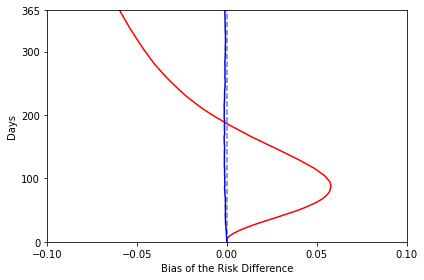

In [8]:
# Plot for inline of notebook
plt.plot(bias_classical, range(0, 366), '-', color='red')
plt.plot(bias_bridged, range(0, 366), '-', color='blue')
plt.vlines(0, 0, 365, colors='gray', linestyles='--')
plt.ylim([0, 365])
plt.yticks([0, 100, 200, 300, 365])
plt.ylabel("Days")
plt.xlim([-0.10, 0.10])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.xlabel("Bias of the Risk Difference")
plt.tight_layout()

In [9]:
# Saving figure as png
plt.figure(figsize=[3, 4.5])
plt.plot(bias_classical, range(0, 366), '-', color='red')
plt.plot(bias_bridged, range(0, 366), '-', color='blue')
plt.vlines(0, 0, 365, colors='gray', linestyles='--')
plt.ylim([0, 365])
plt.yticks([0, 100, 200, 300, 365])
plt.ylabel("Days")
plt.xlim([-0.10, 0.10])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.xlabel("Bias of the Risk Difference")
plt.tight_layout()
plt.savefig("figure_sim_result.png", format='png', dpi=300)
plt.close()

END